In [1]:
import numpy as np
import pandas as pd
import tracktor as tr
import scipy.signal
import cv2
import sys

## Global parameters
This cell (below) enlists user-defined parameters

In [14]:
# colours is a vector of BGR values which are used to identify individuals in the video
# s_id is spider id and is also used for individual identification
# since we only have two individuals, the program will only use the first two elements from these arrays (s_id and colours)
# number of elements in colours should be greater than n_inds (THIS IS NECESSARY FOR VISUALISATION ONLY)
# number of elements in s_id should be greater than n_inds (THIS IS NECESSARY TO GET INDIVIDUAL-SPECIFIC DATA)
n_inds = 2
s_id = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
colours = [(0,0,255),(0,255,255),(255,0,255),(255,255,255),(255,255,0),(255,0,0),(0,255,0),(0,0,0)]

# this is the block_size and offset used for adaptive thresholding (block_size should always be odd)
# these values are critical for tracking performance
block_size = 51
offset = 20

# the scaling parameter can be used to speed up tracking if video resolution is too high (use value 0-1)
scaling = 1.0

# minimum area and maximum area occupied by the animal in number of pixels
# this parameter is used to get rid of other objects in view that might be hard to threshold out but are differently sized
# in this case, the range is wide because males vastly smaller than females
min_area = 100
max_area = 3000000

# kernel for erosion and dilation
# useful since thin spider limbs are sometimes detected as separate objects
kernel = np.ones((5,5),np.uint8)

# mot determines whether the tracker is being used in noisy conditions to track a single object or for multi-object
# using this will enable k-means clustering to force n_inds number of animals
mot = True

# name of source video and paths
video = 'BlackWhiteResult'
input_vidpath = '/Users/ashleyson/Desktop/PSTAT197BC/' + video + '.avi'
output_vidpath = '/Users/ashleyson/Desktop/PSTAT197BC/' + video + '_tracked2.mp4'
output_filepath = '/Users/ashleyson/Desktop/PSTAT197BC/' + video + '_tracked.csv'
codec = 'avc1' # try other codecs if the default doesn't work ('DIVX', 'avc1', 'XVID') note: this list is non-exhaustive

The cell below runs the tracking code

In [15]:
## Open video
cap = cv2.VideoCapture(input_vidpath)
if cap.isOpened() == False:
    sys.exit('Video file cannot be read! Please check input_vidpath to ensure it is correctly pointing to the video file')

## Video writer class to output video with contour and centroid of tracked object(s)
# make sure the frame size matches size of array 'final'
fourcc = cv2.VideoWriter_fourcc(*codec)
output_framesize = (int(cap.read()[1].shape[1]*scaling),int(cap.read()[1].shape[0]*scaling))
out = cv2.VideoWriter(filename = output_vidpath, fourcc = fourcc, fps = 60.0, frameSize = output_framesize, isColor = True)

## Individual location(s) measured in the last and current step
meas_last = list(np.zeros((n_inds,2)))
meas_now = list(np.zeros((n_inds,2)))

last = 0
df = []

while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()

    this = cap.get(1)
    if ret == True:
        frame = cv2.resize(frame, None, fx = scaling, fy = scaling, interpolation = cv2.INTER_LINEAR)
        thresh = tr.colour_to_thresh(frame, block_size, offset)
        thresh = cv2.dilate(thresh, kernel, iterations = 3)
        thresh = cv2.erode(thresh, kernel, iterations = 1)
        final, contours, meas_last, meas_now = tr.detect_and_draw_contours(frame, thresh, meas_last, meas_now, min_area, max_area)
        
        row_ind, col_ind = tr.hungarian_algorithm(meas_last, meas_now)

        final, meas_now, df = tr.reorder_and_draw(final, colours, n_inds, col_ind, meas_now, df, mot, this)

        # Create output dataframe
        for i in range(n_inds):
            df.append([this, meas_now[i][0], meas_now[i][1], s_id[i]])

        # Display the resulting frame
        out.write(final)
        cv2.imshow('frame', final)
        if cv2.waitKey(1) == 27:
            break
            
    if last >= this:
        break
    
    last = this

## Write positions to file
df = pd.DataFrame(np.matrix(df), columns = ['frame','pos_x','pos_y','id'])
df.to_csv(output_filepath, sep=',')

## When everything done, release the capture
cap.release()
out.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

[mjpeg @ 0x7fcb74d6b280] error dc
[mjpeg @ 0x7fcb74d6b280] error y=67 x=119
[mjpeg @ 0x7fcb74d6b280] error dc
[mjpeg @ 0x7fcb74d6b280] error y=67 x=119
[mjpeg @ 0x7fcb74d6b280] error dc
[mjpeg @ 0x7fcb74d6b280] error y=67 x=119
[mjpeg @ 0x7fcb74d6b280] error dc
[mjpeg @ 0x7fcb74d6b280] error y=67 x=119
[mjpeg @ 0x7fcb74d6b280] error dc
[mjpeg @ 0x7fcb74d6b280] error y=67 x=119
[mjpeg @ 0x7fcb74d6b280] error dc
[mjpeg @ 0x7fcb74d6b280] error y=67 x=119


-1

## Summary statistics
The cells below provide functions to perform basic summary statistics - in this case, time spent active vs stationary and the distance between the male and the female.

In [4]:
df = pd.read_csv(output_filepath)
df.head()

,Unnamed: 0,frame,pos_x,pos_y,id
0,0,3.0,427.029786,569.786946,A
1,1,3.0,432.100372,568.808205,B
2,2,4.0,427.054767,569.721937,A
3,3,4.0,432.112856,568.775751,B
4,4,5.0,426.940809,569.784005,A


In [5]:
for idx, ID in enumerate(np.unique(df['id'])):
    df['id'][df['id'] == ID] = idx

/var/folders/61/20r_x2qs5kv9wg256zjpqb_40000gn/T/ipykernel_45623/3124842632.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['id'][df['id'] == ID] = idx


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


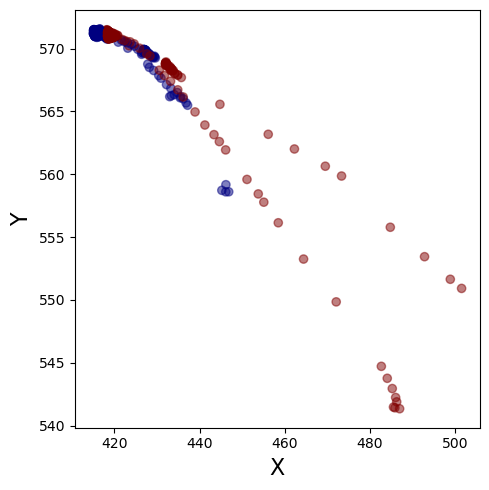

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(df['pos_x'], df['pos_y'], c=df['id'], cmap='jet', alpha=0.5)
plt.xlabel('X', fontsize=16)
plt.ylabel('Y', fontsize=16)
plt.tight_layout()
plt.savefig('imgs/ex3_fig1a.eps', format='eps', dpi=300)
plt.show()

In [7]:
dx = df['pos_x'] - df['pos_x'].shift(2)
dy = df['pos_y'] - df['pos_y'].shift(2)
df['speed'] = np.sqrt(dx**2 + dy**2)
df['cum_dist'] = df['speed'].cumsum()
df = df.sort_values(by=['id', 'frame'])
df.head()

,Unnamed: 0,frame,pos_x,pos_y,id,speed,cum_dist
0,0,3.0,427.029786,569.786946,0,NaN,NaN
2,2,4.0,427.054767,569.721937,0,0.069644,0.069644
4,4,5.0,426.940809,569.784005,0,0.129766,0.234182
6,6,6.0,426.943235,569.838570,0,0.054619,0.353632
8,8,7.0,426.937816,569.799795,0,0.039152,0.451683


In [8]:
## Parameters like speed and acceleration can be very noisy. Small noise in positional data is amplified as we take the
## derivative to get speed and acceleration. We therefore smooth this data to obtain reliable values and eliminate noise.

# the smoothing window parameter determines the extent of smoothing (smoothing window MUST BE ODD)
smoothing_window = 11

## Frame-rate (fps or frames per second) of recorded video to calculate time
fps = 30

In [9]:
smoothed_speed_a = scipy.signal.savgol_filter(df.iloc[np.where(df['id'] == 0)[0],5], smoothing_window, 1)
smoothed_speed_b = scipy.signal.savgol_filter(df.iloc[np.where(df['id'] == 1)[0],5], smoothing_window, 1)
df['smoothed_speed'] = np.array(np.concatenate([smoothed_speed_a, smoothed_speed_b]))

LinAlgError: SVD did not converge in Linear Least Squares

In [10]:
plt.scatter(df['frame']/fps, df['smoothed_speed'], c=df['id'], cmap='jet', s=5, alpha=0.5)
plt.xlabel('Time (s)', fontsize=16)
plt.ylabel('Speed', fontsize=16)
plt.tight_layout()
plt.savefig('imgs/ex3_fig1b.eps', format='eps', dpi=300)
plt.show()

KeyError: 'smoothed_speed'

Time spent active vs. stationary

In [11]:
## Remove nans
smoothed_speed_a = smoothed_speed_a[np.logical_not(np.isnan(smoothed_speed_a))]
smoothed_speed_b = smoothed_speed_b[np.logical_not(np.isnan(smoothed_speed_b))]

## Male
stationary_male = len(np.where(smoothed_speed_b < 1.0)[0])/len(smoothed_speed_b)
active_male = 1 - len(np.where(smoothed_speed_b < 1.0)[0])/len(smoothed_speed_b)

## Female
stationary_female = len(np.where(smoothed_speed_a < 1.0)[0])/len(smoothed_speed_a)
active_female = 1 - len(np.where(smoothed_speed_a < 1.0)[0])/len(smoothed_speed_a)

print('----- The male remains stationary ' + str(stationary_male*100) + '% of the recording -----')
print('----- The female remains stationary ' + str(stationary_female*100) + '% of the recording -----')

NameError: name 'smoothed_speed_a' is not defined

Distance between male and female

In [12]:
distances = []
for fr in np.unique(df['frame']):
    tmp = df[df['frame'] == fr]
    x = tmp[tmp['id'] == 0]['pos_x'].values[0] - tmp[tmp['id'] == 1]['pos_x'].values[0]
    y = tmp[tmp['id'] == 0]['pos_y'].values[0] - tmp[tmp['id'] == 1]['pos_y'].values[0]
    distances.append(np.sqrt(x**2 + y**2))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


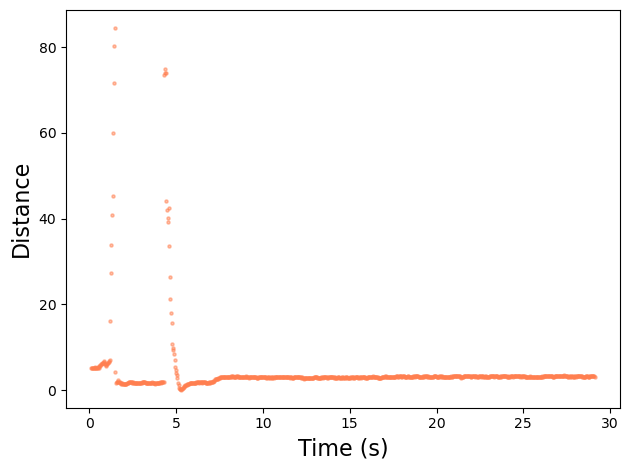

In [13]:
plt.scatter(np.unique(df['frame'])/fps, distances, c='#FF7F50', s=5, alpha=0.5)
plt.xlabel('Time (s)', fontsize=16)
plt.ylabel('Distance', fontsize=16)
plt.tight_layout()
plt.savefig('imgs/ex3_fig2.eps', format='eps', dpi=300)
plt.show()